In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch
from torch.nn import functional as F
import scipy.stats

import sys
sys.path.append("../")
import curvvae_lib.train.predictive_passthrough_trainer as ppttrainer
import curvvae_lib.architecture.passthrough_vae as ptvae
import curvvae_lib.architecture.save_model as sm
import curvvae_lib.architecture.load_model as lm

# Dataset

In [2]:
def ground_truth_parameterization(z):
    x = np.arange(64)
    y = scipy.stats.logistic.cdf(z*np.sin(x*2*np.pi/63))
    return (x,y)

zmax = 5


    
dataset = []
for z in np.linspace(0,zmax,1000):
    x,y = ground_truth_parameterization(z)
    dataset.append(y)
dataset = np.array(dataset)

# 1D PCA Fit to Trajectories

In [3]:
mean = np.mean(dataset,axis=0)
u,s,vt = np.linalg.svd(dataset-mean)

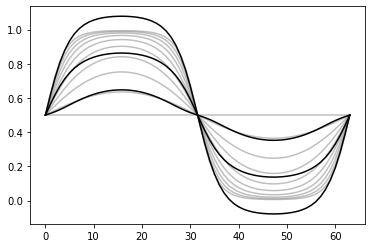

In [4]:
for z in np.linspace(0,zmax,10):
    x,y = ground_truth_parameterization(z)
    plt.plot(x,y,c="gray",alpha=0.5)
plt.plot(np.arange(64),mean              , c = "k")
plt.plot(np.arange(64),mean + 1.5 * vt[0], c = "k")
plt.plot(np.arange(64),mean - 1.5 * vt[0], c = "k")

# 1D VAE Fit to Dataset

In [5]:
def LoadDataBatch(all_points, batchsize, passthroughdim, predictive):
    """Sample Pair of Points from Trajectory"""
    # all_points should be of dimension: num_trajectories, numtimesteps, 1+spatialdims
    traj_ids = np.random.choice(all_points.shape[0], batchsize)
    t1_ids = np.random.choice(all_points.shape[1], batchsize)
    if predictive:
        t2_ids = np.random.choice(all_points.shape[1], batchsize)
    else:
        t2_ids = t1_ids
    return (torch.tensor(all_points[traj_ids, t1_ids,passthroughdim:], dtype=torch.float),
            torch.tensor(all_points[traj_ids, t1_ids,:passthroughdim], dtype=torch.float),
            torch.tensor(all_points[traj_ids, t2_ids,passthroughdim:], dtype=torch.float),
            torch.tensor(all_points[traj_ids, t2_ids,:passthroughdim], dtype=torch.float))

In [6]:
class Loader(object):
    def __init__(self, all_points, batchsize, passthroughdim, epochnumbatches, predictive):
        self.all_points = all_points
        self.batchsize = batchsize
        self.passthroughdim = passthroughdim
        self.epochnumbatches = epochnumbatches
        self.predictive = predictive
        
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        if self.n >= self.epochnumbatches:
            # https://docs.python.org/3/library/exceptions.html#StopIteration
            raise StopIteration
        self.n += 1
        return LoadDataBatch(self.all_points, self.batchsize, self.passthroughdim, self.predictive)
    

train_loader = Loader(dataset[:,np.newaxis,:], 256, 0,1000,predictive=False)
    

In [7]:
def make_vae(latent_dim):
    input_dim = 64 
    passthrough_dim = 0
    emb_layer_widths = [1000]
    recon_layer_widths = [1000]
    dtype = torch.float
    model = ptvae.FCPassthroughVAE(input_dim, passthrough_dim, latent_dim,
        emb_layer_widths, recon_layer_widths, dtype)
    return model

In [9]:
testname = "pedagogical/oned"

In [ ]:
all_exceptions = []
for curvreg in [0,1000,100000]:
    for beta in [1]:
        for latentdim in [1]:
            for epsilon_scale_start in [2]:
                try:
                    vae = make_vae(latent_dim=latentdim)
                    device = "cpu"
                    num_epochs = 100
                    savedir  = f'{testname}lat{latentdim}_secreg0_curvreg{curvreg}_beta{beta}_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
                    print(savedir)
                    trainer = ppttrainer.PPTVAETrainer(vae, train_loader, beta=beta, device=device,
                        log_dir=savedir, lr=0.0005, annealingBatches=0, record_loss_every=300, loss_func = "gaussian")
                    scheduler = torch.optim.lr_scheduler.ExponentialLR(trainer.optimizer, gamma=0.22)
                    epoch = 0
                    epsilon_scale = epsilon_scale_start
                    for _ in range(num_epochs*3):
                        epoch += 1
                        # had an off-by-one error here before
                        # update values BEFORE training 501st element
                        if epoch % num_epochs == 1 and epoch > 1: 
                            scheduler.step()
                            trainer.beta = trainer.beta * 1.0 #0.1
                            epsilon_scale = epsilon_scale * 0.8 #0.1
                        embst = trainer.train(second_deriv_regularizer=0, curvature_regularizer=curvreg, epsilon_scale = epsilon_scale, num_new_samp_points=128)
                        is_error = embst[0]
                        if is_error:
                            raise Exception


                        if epoch % num_epochs == 0:
                            modeled = vae.noiseless_autoencode(allxs, allts)[0].detach().cpu().numpy()
                            print(np.sum(np.square(modeled - allxs.detach().cpu().numpy())))
                            print('====> Epoch: {}'.format(epoch))
                            sm.save_fcpassthrough_vae(vae, savedir+f"_epoch{epoch}")
                    sm.save_fcpassthrough_vae(vae, savedir)
                    print(savedir)
                except:
                    raise

pedagogical/onedlat1_secreg0_curvreg0_beta1_20220131-125421
